Let's load the metadata of the dateset. 'title' and 'journal' attributes may be useful later when we cluster the articles to see what kinds of articles cluster together.

In [50]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json
import os
from tqdm import tqdm
from IPython.display import Image

import pickle

import matplotlib.pyplot as plt
plt.style.use('ggplot')

Let's load the metadata of the dateset. 'title' and 'journal' attributes may be useful later when we cluster the articles to see what kinds of articles cluster together.

In [2]:
#enter path to CORD dataset here (download off Kaggle)
# root_path = 'data/CORD-19-research-challenge/'
root_path = r'C:\Users\aspit\Desktop\CORD-19-research-challenge'

In [34]:
df = pd.read_pickle(os.path.join(root_path, 'df_covid.p'))
# pickle.loads(os.path.join(root_path, 'df_covid.p'))

df = df.sample(n=100, random_state=42)
df.index = range(len(df))


Download the spacy bio parser. <br>
io is used to hide the messy download

In [35]:
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg

### Stopwords

Part of the preprocessing will be finding and removing stopwords (common words that will act as noise in the clustering step).

In [36]:
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['enough',
 'although',
 '’d',
 '’re',
 'yet',
 'amount',
 'with',
 'can',
 'several',
 'together']

Now the above stopwords are used in everyday english text. Research papers will often frequently use words that don't actually contribute to the meaning and are not considered everyday stopwords.

Thank you Daniel Wolffram for the idea.
#### Cite: [Custom Stop Words | Topic Modeling: Finding Related Articles](https://www.kaggle.com/danielwolffram/topic-modeling-finding-related-articles)

In [37]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

### Next lets create a function that will process the text data for us. 
For this purpose we will be using the spacy library. This function will convert text to lower case, remove punctuation, and find and remove stopwords. For the parser, we will use en_core_sci_lg. This is a model for processing biomedical, scientific or clinical text.

In [38]:
# Parser
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

Applying the text-processing function on the **body_text**. 

In [39]:
tqdm.pandas()
df["processed_text"] = df["body_text"].progress_apply(spacy_tokenizer)

C:\Users\aspit\anaconda3\envs\nlp\lib\site-packages\tqdm\std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.97it/s]


### Let's take a look at word count in the papers

In [40]:
import seaborn as sns

In [41]:
# df['processed_text'][0]

count      100.000000
mean      4741.680000
std       2110.206423
min       1301.000000
25%       3238.750000
50%       4598.500000
75%       5847.750000
max      12867.000000
Name: body_word_count, dtype: float64

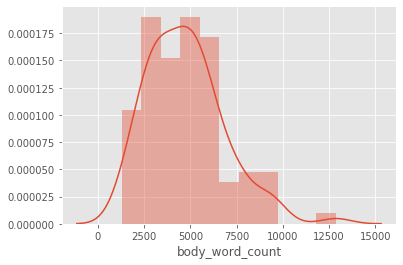

In [42]:
sns.distplot(df['body_word_count'])
df['body_word_count'].describe()

count     100.000000
mean     1455.890000
std       493.051637
min       559.000000
25%      1091.750000
50%      1440.500000
75%      1721.750000
max      3055.000000
Name: body_unique_words, dtype: float64

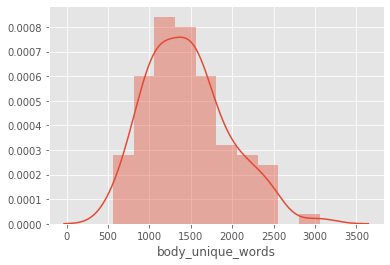

In [43]:
sns.distplot(df['body_unique_words'])
df['body_unique_words'].describe()

These two plots give us a good idea of the content we are dealing with. Most papers are about 5000 words in length. The long tails in both plots are caused by outliers. In fact, ~98% of the papers are under 20,000 words in length while a select few are over 200,000! <br><br>

# Vectorization

Now that we have pre-processed the data, it is time to convert it into a format that can be handled by our algorithms. For this purpose we will be using tf-idf. This will convert our string formatted data into a measure of how important each word is to the instance out of the literature as a whole.

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

Vectorize our data. We will be clustering based off the content of the body text. The maximum number of features will be limited. Only the top 2 ** 12 features will be used, eseentially acting as a noise filter. Additionally, more features cause painfully long runtimes.

In [45]:
text = df['processed_text'].values
X = vectorize(text, 2 ** 12)
X.shape

(100, 4096)

# PCA  & Clustering

Let's see how much we can reduce the dimensions while still keeping 95% variance. We will apply Principle Component Analysis (PCA) to our vectorized data. The reason for this is that by keeping a large number of dimensions with PCA, you don’t destroy much of the information, but hopefully will remove some noise/outliers from the data, and make the clustering problem easier for k-means. Note that X_reduced will only be used for k-means, t-SNE will still use the original feature vector X that was generated through tf-idf on the NLP processed text.

(Thank you Dr. Edward Raff for the suggestion)

In [46]:
from sklearn.decomposition import PCA

In [47]:
pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(100, 90)

To separate the literature, k-means will be run on the vectorized text. Given the number of clusters, k, k-means will categorize each vector by taking the mean distance to a randomly initialized centroid. The centroids are updated iteratively.

In [48]:
from sklearn.cluster import KMeans

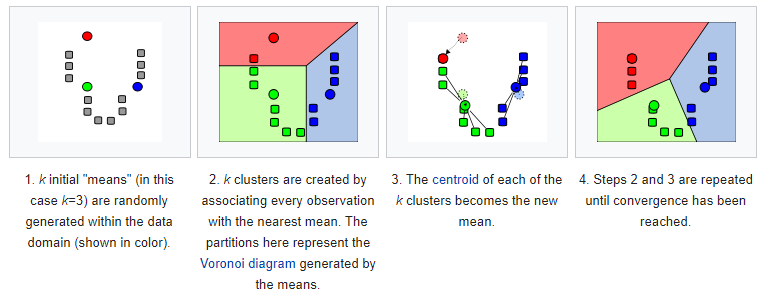

In [51]:
Image(filename='resources/kmeans.png', width=800, height=800)

[source](https://en.wikipedia.org/wiki/K-means_clustering)

### How many clusters? 

To find the best k value for k-means we'll look at the distortion at different k values. Distortion computes the sum of squared distances from each point to its assigned center. When distortion is plotted against k there will be a k value after which decreases in distortion are minimal. This is the desired number of clusters.

In [52]:
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 40)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42, n_jobs=-1).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

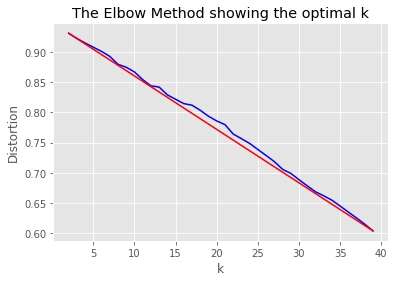

In [53]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In this plot we can see that the better k values are between 18-25. After that, the decrease in distortion is not as significant. For simplicity, we will use k=20

### Run k-means

Now that we have an appropriate k value, we can run k-means on the PCA-processed feature vector (X_reduced). 

In [54]:
k = 20
kmeans = KMeans(n_clusters=k, random_state=42, n_jobs=-1)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

# Dimensionality Reduction with t-SNE

Using [t-SNE](https://lvdmaaten.github.io/tsne) we can reduce our high dimensional features vector to 2 dimensions. By using the 2 dimensions as x,y coordinates, the body_text can be plotted. 

> t-Distributed Stochastic Neighbor Embedding (t-SNE) reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space
> #### Cite: [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow: Second Edition | Aurélien Geron](https://github.com/ageron/handson-ml2)

In [55]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.828701
[t-SNE] KL divergence after 400 iterations: 0.000001


In [56]:
len(X_embedded)

100

So that step took a while! Let's take a look at what our data looks like when compressed to 2 dimensions. 

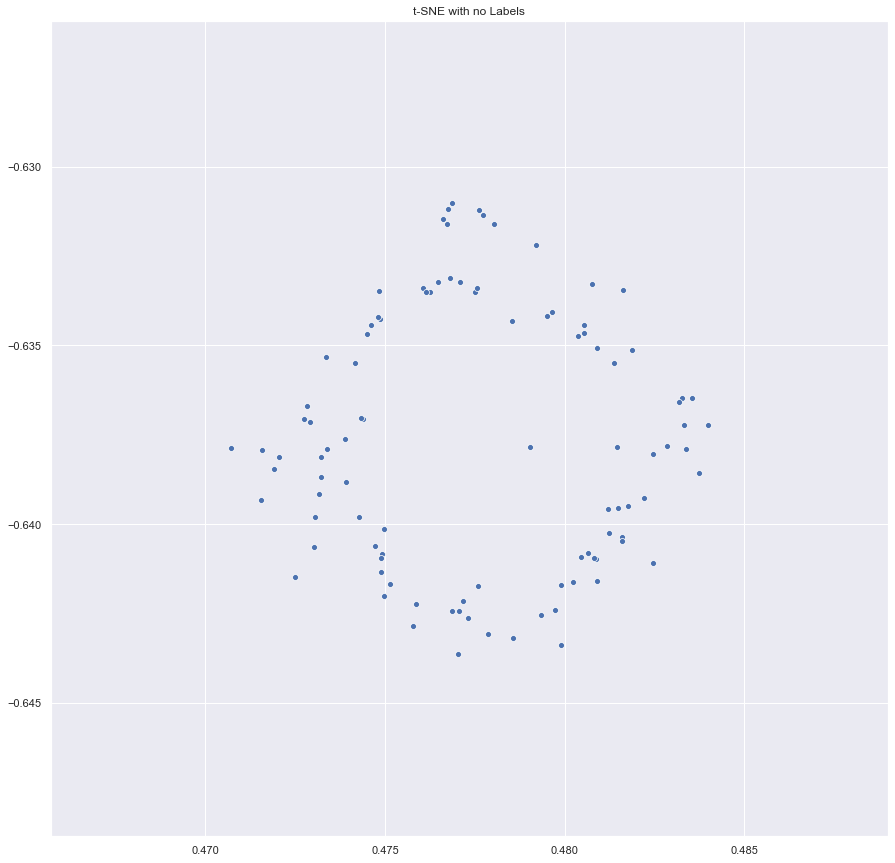

In [57]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("plots/t-sne_covid19.png")
plt.show()

This looks pretty bland. There are some clusters we can immediately detect, but the many instances closer to the center are harder to separate. t-SNE did a good job at reducing the dimensionality, but now we need some labels. Let's use the clusters found by k-means as labels. This will help visually separate different concentrations of topics.

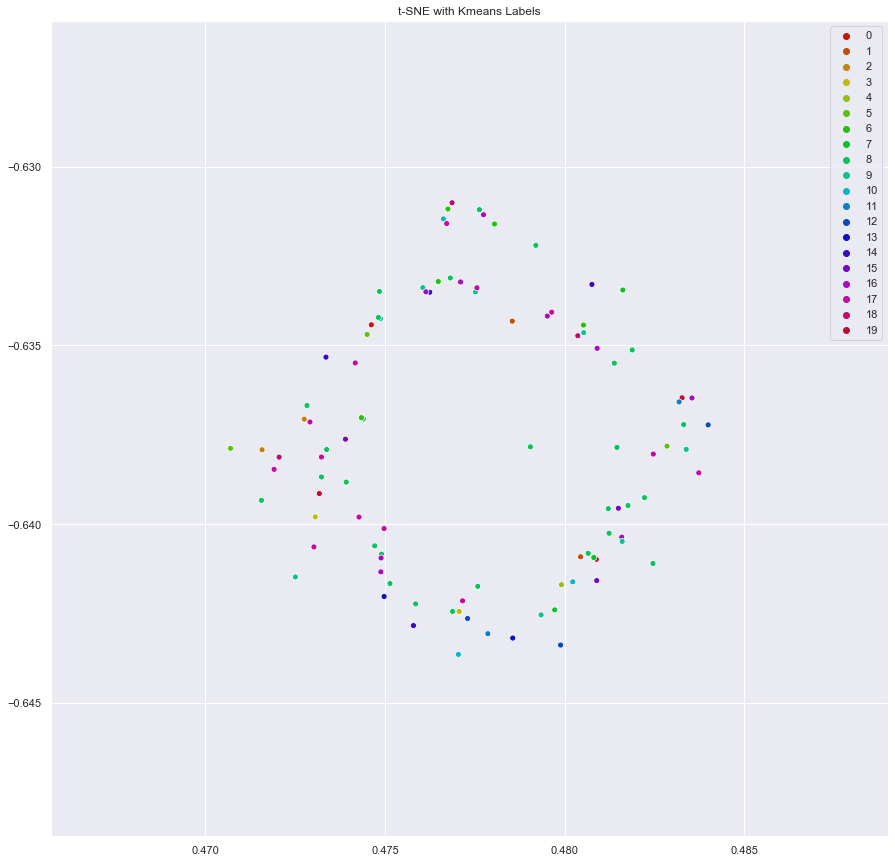

In [58]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15, 15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("plots/improved_cluster_tsne.png")
plt.show()

The labeled plot gives better insight into how the papers are grouped. It is interesting that both k-means and t-SNE are able to agree on certain clusters even though they were ran independetly. The location of each paper on the plot was determined by t-SNE while the label (color) was determined by k-means. If we look at a particular part of the plot where t-SNE has grouped many articles forming a cluster, it is likely that k-means is uniform in the labeling of this cluster (most of the cluster is the same color). This behavior shows that structure within the literature can be observed and measured to some extent. 

Now there are other cases where the colored labels (k-means) are spread out on the plot (t-SNE). This is a result of t-SNE and k-means finding different connections in the higher dimensional data. The topics of these papers often intersect so it hard to cleanly separate them. This effect can be observed in the formation of subclusters on the plot. These subclusters are a conglomeration of different k-means labels but may share some connection determined by t-SNE.

This organization of the data does not act as a simple search engine. The clustering + dimensionality reduction is performed on the mathematical similarities of the publications. As an unsupervised approach, the algorithms may even find connections that were unnaparent to humans. This may highlight hidden shared information and advance further research.

# Topic Modeling on Each Cluster

Now we will attempt to find the most significant words in each clusters. K-means clustered the articles but did not label the topics. Through topic modeling we will find out what the most important terms for each cluster are. This will add more meaning to the cluster by giving keywords to quickly identify the themes of the cluster.

For topic modeling, we will use LDA (Latent Dirichlet Allocation). In LDA, each document can be described by a distribution of topics and each topic can be described by a distribution of words[.](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158)

In [59]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

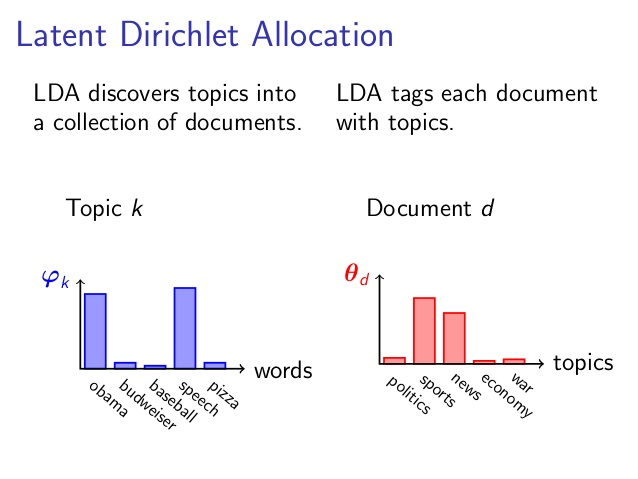

In [60]:
Image(filename='resources/lda.jpg', width=600, height=600)

[source](https://towardsdatascience.com/latent-dirichlet-allocation-15800c852699)

First we will create 20 vectorizers, one for each of our cluster labels

In [61]:
vectorizers = []
    
for ii in range(0, 20):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [62]:
vectorizers[0]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.9, max_features=None, min_df=5,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}',
                tokenizer=None, vocabulary=None)

Now we will vectorize the data from each of our clusters

In [63]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

Not enough instances in cluster: 0
Not enough instances in cluster: 1
Not enough instances in cluster: 2
Not enough instances in cluster: 3
Not enough instances in cluster: 4
Not enough instances in cluster: 5
Not enough instances in cluster: 6
Not enough instances in cluster: 7
Not enough instances in cluster: 10
Not enough instances in cluster: 11
Not enough instances in cluster: 12
Not enough instances in cluster: 13
Not enough instances in cluster: 14
Not enough instances in cluster: 15
Not enough instances in cluster: 18
Not enough instances in cluster: 19


In [64]:
len(vectorized_data)

20

Topic modeling will be performed through the use of Latent Dirichlet Allocation (LDA). This is a generative statistical model that allows sets of words to be explained by a shared topic

In [65]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 20

lda_models = []
for ii in range(0, 20):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=False)

For each cluster, we had created a correspoding LDA model in the previous step. We will now fit_transform all the LDA models on their respective cluster vectors

In [66]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

Extracts the keywords from each cluster

In [67]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

Append list of keywords for a single cluster to 2D list of length NUM_TOPICS_PER_CLUSTER

In [68]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

In [70]:
all_keywords[0][:10]

['antibody',
 'image',
 'map',
 'term',
 'method',
 'spike',
 'epitope',
 'mouse',
 'cancer',
 'disease']

In [69]:
len(all_keywords)

4

### Save current outputs to file

Re-running some parts of the notebook (especially vectorization and t-SNE) are time intensive tasks. We want to make sure that the important outputs for generating the bokeh plot are saved for future use.

In [71]:
f=open('lib/topics.txt','w')

count = 0

for ii in all_keywords:

    if vectorized_data[count] != None:
        f.write(', '.join(ii) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(ii) + "\n")
    count += 1

f.close()

In [73]:
# import pickle

# # save the COVID-19 DataFrame, too large for github
# pickle.dump(df, open("plot_data/df_covid.p", "wb" ))

# # save the final t-SNE
# pickle.dump(X_embedded, open("plot_data/X_embedded.p", "wb" ))

# # save the labels generate with k-means(20)
# pickle.dump(y_pred, open("plot_data/y_pred.p", "wb" ))

# Classify

Though arbitrary, after running kmeans, the data is now 'labeled'. This means that we now use supervised learning to see how well the clustering generalizes. This is just one way to evaluate the clustering. If k-means was able to find a meaningful split in the data, it should be possible to train a classifier to predict which cluster a given instance should belong to. 

In [74]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")

Let's split the data into train/test sets

In [75]:
from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(X.toarray(),y_pred, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 80
X_test size: 20 



Now let's create a Stochastic Gradient Descent classifier 

**Precision** is ratio of True Positives to True Positives + False Positives. This is the accuracy of positive predictions<br>
**Recall** (also known as TPR) measures the ratio of True Positives to True Positives + False Negatives. It measures the ratio of positive instances that are correctly detected by the classifer.<br>
**F1 score**  is the harmonic average of the precision and recall. F1 score will only be high if both precision and recall are high

#### Cite: [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow: Second Edition | Aurélien Geron](https://github.com/ageron/handson-ml2)

In [76]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=-1)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=-1)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  26.250 %
     Precision:  9.458 %
        Recall:  9.706 %
      F1 score:  6.804 %


C:\Users\aspit\anaconda3\envs\nlp\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\aspit\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


To test for overfitting, let's see how the model generalizes over the test set

In [77]:
# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=3, n_jobs=-1)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_test, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  55.000 %
     Precision:  6.111 %
        Recall:  11.111 %
      F1 score:  7.885 %


C:\Users\aspit\anaconda3\envs\nlp\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\aspit\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Now let's see how the model can generalize across the whole dataset. 

In [78]:
sgd_cv_score = cross_val_score(sgd_clf, X.toarray(), y_pred, cv=10)
print("Mean cv Score - SGD: {:,.3f}".format(float(sgd_cv_score.mean()) * 100), "%")

C:\Users\aspit\anaconda3\envs\nlp\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Mean cv Score - SGD: 43.000 %


# Plotting the data
The previous steps have given us clustering labels and a dataset of papers reduced to two dimensions. By pairing this with Bokeh, we can create an interactive plot of the literature. This should organize the papers such that related publications are in close proximity. To try to undertstand what the similarities may be, we have also performed topic modelling on each cluster of papers in order to pick out the key terms.

Bokeh will pair the actual papers with their positions on the t-SNE plot. Through this approach it will be easier to see how papers fit together, allowing for both exploration of the dataset and evaluation of the clustering. 

In [79]:
# required libraries for plot
from lib.plot_text import header, description, description2, cite, description_search, description_slider, notes, dataset_description, toolbox_header 
from lib.call_backs import input_callback, selected_code
import bokeh
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, Slider, TapTool, TextInput
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap, transform
from bokeh.io import output_file, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import RadioButtonGroup, TextInput, Div, Paragraph
from bokeh.layouts import column, widgetbox, row, layout
from bokeh.layouts import column

## Load the Keywords per Cluster

In [80]:
import os

topic_path = os.path.join(os.getcwd(), 'lib', 'topics.txt')
with open(topic_path) as f:
    topics = f.readlines()

## Setup

In [81]:
import random

# show on notebook
output_notebook()
# target labels
y_labels = y_pred

# data sources
source = ColumnDataSource(data=dict(
    x= X_embedded[:,0], 
    y= X_embedded[:,1],
    x_backup = X_embedded[:,0],
    y_backup = X_embedded[:,1],
    desc= y_labels, 
    titles= df['title'],
    authors = df['authors'],
    journal = df['journal'],
    abstract = df['abstract_summary'],
    labels = ["C-" + str(x) for x in y_labels],
    links = df['doi']
    ))

# hover over information
hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    ("Author(s)", "@authors{safe}"),
    ("Journal", "@journal"),
    ("Abstract", "@abstract{safe}"),
    ("Link", "@links")
],
point_policy="follow_mouse")

# map colors
initial_palette = Category20[20]
random.Random(42).shuffle(initial_palette)

mapper = linear_cmap(field_name='desc', 
                     palette=Category20[20],
                     low=min(y_labels) ,high=max(y_labels))

# prepare the figure
plot = figure(plot_width=1200, plot_height=850, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset', 'save', 'tap'], 
           title="Clustering of the COVID-19 Literature with t-SNE and K-Means", 
           toolbar_location="above")

# plot settings
plot.scatter('x', 'y', size=5, 
          source=source,
          fill_color=mapper,
          line_alpha=0.3,
          line_width=1.1,
          line_color="black",
          legend = 'labels')
plot.legend.background_fill_alpha = 0.6

Loading BokehJS ...

## Widgets

In [82]:
# Keywords
text_banner = Paragraph(text= 'Keywords: Slide to specific cluster to see the keywords.', height=25)
input_callback_1 = input_callback(plot, source, text_banner, topics)

# currently selected article
div_curr = Div(text="""Click on a plot to see the link to the article.""",height=150)
callback_selected = CustomJS(args=dict(source=source, current_selection=div_curr), code=selected_code())
taptool = plot.select(type=TapTool)
taptool.callback = callback_selected

# WIDGETS
slider = Slider(start=0, end=20, value=20, step=1, title="Cluster #", callback=input_callback_1)
keyword = TextInput(title="Search:", callback=input_callback_1)

# pass call back arguments
input_callback_1.args["text"] = keyword
input_callback_1.args["slider"] = slider
# column(,,widgetbox(keyword),,widgetbox(slider),, notes, cite, cite2, cite3), plot

## Style

In [83]:
# STYLE
header.sizing_mode = "stretch_width"
header.style={'color': '#2e484c', 'font-family': 'Julius Sans One, sans-serif;'}
header.margin=5

description.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description.sizing_mode = "stretch_width"
description.margin = 5

description2.sizing_mode = "stretch_width"
description2.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description2.margin=10

description_slider.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description_slider.sizing_mode = "stretch_width"

description_search.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description_search.sizing_mode = "stretch_width"
description_search.margin = 5

slider.sizing_mode = "stretch_width"
slider.margin=15

keyword.sizing_mode = "scale_both"
keyword.margin=15

div_curr.style={'color': '#BF0A30', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
div_curr.sizing_mode = "scale_both"
div_curr.margin = 20

text_banner.style={'color': '#0269A4', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
text_banner.sizing_mode = "scale_both"
text_banner.margin = 20

plot.sizing_mode = "scale_both"
plot.margin = 5

dataset_description.sizing_mode = "stretch_width"
dataset_description.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
dataset_description.margin=10

notes.sizing_mode = "stretch_width"
notes.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
notes.margin=10

cite.sizing_mode = "stretch_width"
cite.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
cite.margin=10

r = row(div_curr,text_banner)
r.sizing_mode = "stretch_width"

## SHOW

In [84]:
# LAYOUT OF THE PAGE
l = layout([
    [header],
    [description],
    [description_slider, description_search],
    [slider, keyword],
    [text_banner],
    [div_curr],
    [plot],
    [description2, dataset_description, notes, cite],
])
l.sizing_mode = "scale_both"


# show
output_file('plots/t-sne_covid-19_interactive.html')
show(l)

# How to Use the Plot?

Each dot on the plot represents a research article. They are color-coded by the cluster number that kmeans had found. By default no cluster is selected and all the clusters are displayed. To select a distinct cluster, set the slider to the desired cluster number. When an individual cluster is selected, a list of keywords found in that cluster will be displayed above the plot.You can also search for articles by specific keyword, either within an individual cluster or within all. Let's go through an example of how the tool can be used. 

**Note, This example is pulled from an older version of the plot, functionality remains the same:** <br>

First let's check out the different clusters and see if anything interesting stands out. The easiest way to get a general idea of what is going on in each cluster is to look to the keywords for each cluster (the ones we identified through topic modeling). For the sake of example, let's say we see some keywords that interest us in cluster #9. This cluster seems to center around livestock

In [ ]:
Image(filename="demo/cluster_9_keywords.png", width=1170, height=60)

<br>

And here is what the actual cluster looks like, zoomed in on the plot:

In [ ]:
Image(filename='demo/cluster_9.png', width=420, height=375)

Now let's say we interested specifically in cattle. Let's use the keyword search to filter for papers that specifically mention cattle. This is what the same cluster will look like now:

In [ ]:
Image(filename='demo/cluster_9_cattle.png', width=420, height=375)

The shown articles are now a little thinner, showing only papers that are part of the cluster and that contain the keyword 'cattle'. The search can also be expanded to the entire dataset by setting the # of clusters to the default value of 20. Hovering over any article will give basic information like title, author, and abstract. Clicking on an article will pin that article above the plot and give a URL that will direct the user to the full paper. Here's what clicking an article looks like:

In [ ]:
Image(filename='demo/selected_paper.png', width=600, height=100)

# Examples
The plot can be used to quickly find many publications on a similar topic. For example, let's say we're interested in finding information on masks and their effectiveness. To do this we can either try to find a cluster with a keyword such as "mask" or we can search for the term directly and try to identify which cluster it most closely relates to.

If you search for "mask" cluster #12 is well represented. It would be wise to start the looking there. A quick scan of the titles indicates that these publications mainly address different masks and their uses for healthcare workers.

Searching for a single key term may cause you to inadvertenly filter out highly similar papers that use different phrasing. After an initial examination, clear the search term and explore the whole cluster by adjusting the slider. In this case, we would set the slider to 12 and look for more interesting papers in the entire cluster.

Now we will explore a couple task-oriented questions. <br><br>

### What do we know about diagnostics and surveillance?
#### Diagnostics
- To start, we first searched one of the keyterms from this question ("diagnostic")
- For "diagnostic", cluster #17 stood out immediately
- Next we removed the search term and adjusted the slider to 17
- Inside cluster 17 there exists a main cluster and a smaller, denser sub-cluster just off to the right of the main one. Both this main cluster and the sub-cluster seem to contain useful information on diagnosing viral infections. Just quickly skimming through the publications, we saw papers such as:

    - [Evaluation of fast-track diagnostics and TaqMan array card real-time PCR assays for the detection of respiratory pathogens](https://www.sciencedirect.com/science/article/pii/S0167701214002991?via%3Dihub)
    - [Advances in the diagnosis of respiratory virus infections](https://www.sciencedirect.com/science/article/pii/0928019796002103?via%3Dihub)

#### Surveillance
- Next, we returned to the full plot by adjusting the slider to cluster 20 (clusters range from 0 to 19; 20 plots all)
- We then repeated the search process with keyterm "surveillance"
- The dominant cluster for this search term was cluster #8. After clearing the search box and adjusting the slider to 8, we looked at some of the titles and abstracts in this cluster
- A couple that stood out:

    - [Surveillance strategy for early detection of unusual infectious disease events](https://www.sciencedirect.com/science/article/pii/S1879625713000217?via%3Dihub)
    - [Communicable Disease Surveillance Ethics in the Age of Big Data and New Technology](https://link.springer.com/article/10.1007/s41649-019-00087-1)


### What do we know about vaccines and therapeutics?
#### Vaccine
- To identify which cluster to examine first for papers on vaccines, we used a different strategy than before
- By examinining the keywords generated through topic modeling for each cluster, we found that cluster #15 had related keywords like "vaccine", "serum", and "delivery"
- To further verify, we also searched for "vaccine" within the whole dataset and found that cluster #15 was well represented
- While exploring this cluster we ran into an issue of overrepresentation - many publications focused on vaccines that seemed unrelated. To remedy this we searched for "corona" within the cluster
- This narrowed down the publications and made it easier to look for interesting papers. Here are a few that we found:

    - [Development of next-generation respiratory virus vaccines through targeted modifications to viral immunomodulatory genes](https://www.tandfonline.com/doi/full/10.1586/14760584.2015.1095096)
    - [Intranasal DNA Vaccine for Protection against Respiratory Infectious Diseases: The Delivery Perspectives](https://www.mdpi.com/1999-4923/6/3/378)

#### Therapeutics
- Cluster #1 has more information on vaccine/therapeutics
- Specifically, there is a lot of information on coronaviruses (the top keyword in the cluster is MERS)
- A few interesting papers from cluster #1:

    - [A safe and convenient pseudovirus-based inhibition assay to detect neutralizing antibodies and screen for viral entry inhibitors against the novel human coronavirus MERS-CoV](https://virologyj.biomedcentral.com/articles/10.1186/1743-422X-10-266)
    - [Advances in MERS-CoV Vaccines and Therapeutics Based on the Receptor-Binding Domain](https://www.mdpi.com/1999-4915/11/1/60)

# Conclusion
In this project, we have attempted to cluster published literature on COVID-19 and reduce the dimensionality of the dataset for visualization purposes. This has allowed for an interactive scatter plot of papers related to COVID-19, in which material of similar theme is grouped together. Grouping the literature in this way allows for professionals to quickly find material related to a central topic. Instead of having to manually search for related work, every publication is connected to a larger topic cluster. The clustering of the data was done through k-means on a pre-processed, vectorized version of the literature’s body text. As k-means simply split the data into clusters, topic modeling through LDA was performed to identify keywords. This gave the topics that were prevalent in each of the clusters. Both the clusters and keywords are found through unsupervised learning models and can be useful in revealing patterns that humans may not have even thought about. In no part of this project did we have to manually organize the papers: the results are due to latent connections in the data. 
 
K-means (represented by colors) and t-SNE (represented by points) were able to independently find clusters, showing that relationships between papers can be identified and measured. Papers written on highly similar topics are typically near each other on the plot and bear the same k-means label. However, due to the complexity of the dataset, k-means and t-SNE will sometimes arrive at different decisions. The topics of much of the given literature are continuous and will not have a concrete decision boundary. This may mean that k-means and t-SNE can find different similarities to group the papers by. In these conditions, our approach performs quite well.

As this is an unsupervised learning problem, the evaluation of our work was not an exact science. First, the plot was examined to assert that clusters were actually being formed. After being convinced of this, we examined the titles/abstracts of some of the papers in different clusters. For the most part, similar research areas were clustered. Our last evaluation method was classification. By training a classification model with the k-means labels and then testing it on a separate subset of the data, we could see that the clustering was not completely arbitrary as the classifier performed well. 

Our manual inspection of the documents was quite limited, as neither of the authors are qualified to assess the meaning of the literature. Even so, it was apparent that articles on key topics could be easily found in close proximity to each other. For example, searching for 'mask' can reveal a sub cluster of papers that evaluate the efficacy of masks.  We believe that health professionals can use this tool to find real links in the texts. By organizing the literature, qualified people can quickly find related publications that answer the task questions. This project can further be improved by abstracting the underlying data analysis techniques as described in this notebook to develop a user interface/tool that presents the related articles in a user-friendly manner.


<br>
<br>
<br>

**Some areas we thought were great:** (pros)
- The tool is saved as an html file. It can be downloaded and used locally/offline.
- It is portable/mobile, easily deployable, and failover safe; the risk of denial of service in the case of emergencies such as the loss of network connection is mitigated
- Dimensionality reduction allows for the whole dataset to be easily accessible. The papers are all up on the plot and can be quickly examined by hovering over them. If the abstract seems interesting, the user can click on the point to bring up a text box with more information that will contain a link to the full paper
- Patterns in the data found through clustering/dimensionality reduction may not be readily apparent to researchers. These unsupervised techniques can show humans hidden connnections in the literature
- If the topics/clusters are not narrow enough for the user, a search for a key term that will only bring up papers that contain the search term. Search can be performed inside of a selected cluster or the entire dataset if preferred. This increases the flexibility of how patterns can be discovered.
- A surface level examination of the plot showed some very interesting organization of the data. For example, one subcluster consisted of papers that tried to determine the efficacy of masks in preventing the spread of COVID-19.
- Once the models are trained, the results can be generated in constant time.
- This work can be easily replicated and modified as needed, serving as a foundation for future projects.

<br>

**Future thoughts to consider:** (cons)
- Possible false positives, difficult to draw an exact line between subjects
- K-means and t-SNE are unsupervised approaches that will not necessarily group instances in a predictable way. Due to their unsupervised nature, there is no 'right answer' for how the papers should be clustered. This could be difficult to debug if problems arise.
- Loss of foreign language papers. This leads to the loss of experience from different geographic locations on dealing with COVID-19
- The algorithms used in this notebook are stochastic so the results may vary depending on the random state. In this notebook all of the algorithms are set to random state 42 (the meaning of life) to ensure reproducible results
- Long run time to train models on large dataset of literature

# Citation/Sources

Kaggle Submission: [COVID-19 Literature Clustering | Kaggle](https://www.kaggle.com/maksimeren/covid-19-literature-clustering#Unsupervised-Learning:-Clustering-with-K-Means)
 
 ```
@inproceedings{Raff2020,
	author = {Raff, Edward and Nicholas, Charles and McLean, Mark},
	booktitle = {The Thirty-Fourth AAAI Conference on Artificial Intelligence},
	title = {{A New Burrows Wheeler Transform Markov Distance}},
	url = {http://arxiv.org/abs/1912.13046},
	year = {2020},
}
```
```
@misc{Kaggle,
	author = {Kaggle},
	title = {COVID-19 Open Research Dataset Challenge (CORD-19)},
	year = {2020},
	month = {March},
	note = {Allen Institute for AI in partnership with the Chan Zuckerberg Initiative, Georgetown University’s Center for   Security and Emerging Technology, Microsoft Research, and the National Library of Medicine - National Institutes of Health, in coordination with The White House Office of Science and Technology Policy.},
	howpublished = {\url{https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge}}
}
```
```
@inproceedings{Shakespeare,
	author = {Nicholas, Charles},
	title = {Mr. Shakespeare, Meet Mr. Tucker},
	booktitle = {High Performance Computing and Data Analytics Workshop},
	year = {2019},
	month = {September},
	location = { Linthicum Heights, MD, USA},
}
```
```
@inproceedings{raff_lzjd_2017,
	author = {Raff, Edward and Nicholas, Charles},
	title = {An Alternative to NCD for Large Sequences, Lempel-Ziv Jaccard Distance},
	booktitle = {Proceedings of the 23rd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining},
	series = {KDD '17},
	year = {2017},
	isbn = {978-1-4503-4887-4},
	location = {Halifax, NS, Canada},
	pages = {1007--1015},
	numpages = {9},
	url = {http://doi.acm.org/10.1145/3097983.3098111},
	doi = {10.1145/3097983.3098111},
	acmid = {3098111},
	publisher = {ACM},
	address = {New York, NY, USA},
	keywords = {cyber security, jaccard similarity, lempel-ziv, malware classification, normalized compression distance},
}
```
```
@inproceedings{ML_Book,
    author = {Aurélien Geron},
    title = {Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow},
    pages = {91, 233},
    series = {2},
    year = {2019},
    isbn = {978-1-492-03264-9},
    publisher = {O'Reilly},
    copyright = {Kiwisoft S.A.S},
}
```

<br>
<br>